## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
import string

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

In [3]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text="".join([t.lower() for t in text])

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

In [6]:
tokens

['\n',
 ' ',
 '!',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 ':',
 ';',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
import numpy as np

In [8]:
def create_enmbending(index, size):
    embending=np.zeros(size)
    embending[index] = 1
    return embending

tokens_quant = len(tokens)

# dict <index>:<char>
idx_to_token = {tuple(create_enmbending(tokens.index(t), tokens_quant))  : t for t in tokens }


# dict <char>:<index>

token_to_idx = {t : create_enmbending(tokens.index(t), tokens_quant) for t in tokens }

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [10]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.rnn_update = nn.Linear(tokens_quant + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, len(tokens))
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x, h_prev], dim=1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE
        
        h_next = torch.tanh(h_next) # YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)# YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [11]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length, _ = batch_ix.size()

    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []


    for x_t in batch_ix.transpose(0,1):

        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [12]:
from IPython.display import clear_output
import random

Немного подготовим данные: сделаем все строки ожинаковой длины, добавив в конец нужное кол-во ' '

In [13]:
string_list = text.split('\n')
#  Уберем пустые строки и строки заголовков
string_list = [i for i in string_list if len(i)>8]
MAX_LENGTH = max([len(s) for s in string_list])
string_list_fullfilled = [s+' '*(MAX_LENGTH - len(s)) for s in string_list]
add_embd = lambda input: [token_to_idx[s] for s in input]
string_list_fullfilled = [add_embd(s) for s in string_list_fullfilled]

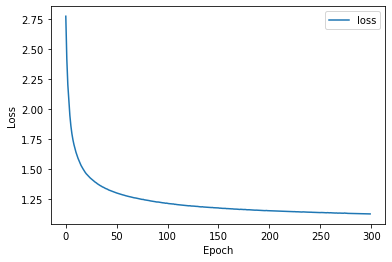

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
history = []
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())

batch_size = 32

for epoch in range(300):

    shufeled = string_list_fullfilled
    random.shuffle(shufeled)

    batch_history=[]
    # print(shufeled)
    for i in range(0, len(shufeled) - batch_size + 1, batch_size):
        # print(i)
        batch_ix = shufeled[i:i+batch_size]
        # batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.float32)

        
        logp_seq = rnn_loop(char_rnn, batch_ix)
        
        # compute loss
        predictions_logp = logp_seq[:, :-1, :]# YOUR CODE HERE
        actual_next_tokens = batch_ix[:, 1:, :]# YOUR CODE HERE
        

        loss = criterion(
            predictions_logp.contiguous().view(-1, tokens_quant),
            torch.argmax(actual_next_tokens, dim=2).contiguous().view(-1))# YOUR CODE HERE
        
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        # YOUR CODE HERE
        
        batch_history.append(loss.data.numpy())
    history.append(np.mean(batch_history))
    if (i+1)%1==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [25]:
def generate_sample(char_rnn, seed_phrase='  hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.float32).T
    hid_state = char_rnn.initial_state(batch_size=1)
    # print(x_sequence)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, i].view(1,-1).shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i].view(1,-1), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, -1].view(1,-1), hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        # print(p_next)
        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        next_embd = create_enmbending(next_ix, tokens_quant)
        torch_next_embd = torch.tensor(next_embd, dtype=torch.float32).view(1,-1).T
        # print(x_sequence.shape, torch_next_embd.shape)
        x_sequence = torch.cat([x_sequence, torch_next_embd], dim=1)
    tmp = x_sequence.data.numpy()
    return ''.join([idx_to_token[tuple([int(i) for i in ix])] for ix in x_sequence.T.data.numpy()])
    # return tmp

In [26]:
for i in np.linspace(0.1, 2, 10):
    print('temperature = ', round(i,1), '\n', generate_sample(char_rnn, temperature=i/10))


temperature =  0.1 
   hellons shall the worth the stard the worth the worth the st
temperature =  0.3 
   hellons shall the worth the stard the worth the stard the wo
temperature =  0.5 
   hellone,                                                    
temperature =  0.7 
   hellone,                                                    
temperature =  0.9 
   hellons seem the worth the though the stard the proud the wo
temperature =  1.2 
   hellons shall the stard the proud the will my self the worth
temperature =  1.4 
   hellone my seem the decelf ar thee the stard the stard the s
temperature =  1.6 
   hellows be so doth be the worth the will my love then the st
temperature =  1.8 
   hellons beauty be the stard the worth the strong thee be the
temperature =  2.0 
   hellons from the worth the world my self the stant the strin


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [17]:
class CharLSTMCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), lstm_num_units=64):
        super(self.__class__,self).__init__()
        self.lstm_num_units = lstm_num_units
        
        self.lstm_update = nn.LSTM(num_tokens, lstm_num_units)
        self.lstm_to_logits = nn.Linear(lstm_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous lstm hidden states, containing matrix [batch, lstm_num_units] of float32
        """

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        # x_and_h = torch.cat([x, h_prev], dim=1) # YOUR CODE HERE
        # print(x.shape, h_prev.shape)
        lstm_out, h_next = self.lstm_update(x, h_prev)  # YOUR CODE HERE
        
        # h_next = torch.tanh(h_next) # YOUR CODE HERE

        
        # assert h_next.size() == h_prev.size()

        
        #compute logits for next character probs
        logits = self.lstm_to_logits(lstm_out)# YOUR CODE

        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.lstm_num_units, requires_grad=True), torch.zeros(1, batch_size, self.lstm_num_units, requires_grad=True)

In [18]:
def loop(char_lstm, batch_ix):
    """

    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length, _ = batch_ix.size()

    hid_state= char_lstm.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):

        hid_state, logp_next = char_lstm(x_t.view(1,batch_size,-1), hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=2)

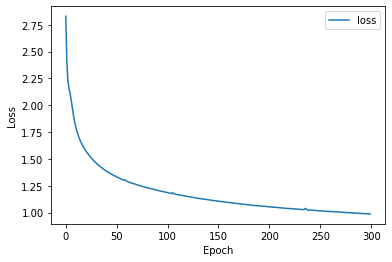

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
history = []
char_lstm = CharLSTMCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_lstm.parameters())

batch_size = 32

for epoch in range(300):

    shufeled = string_list_fullfilled
    random.shuffle(shufeled)

    batch_history=[]
    # print(shufeled)
    for i in range(0, len(shufeled) - batch_size + 1, batch_size):
        # print(i)
        batch_ix = shufeled[i:i+batch_size]
        # batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.float32)


        logp_seq = loop(char_lstm, batch_ix)
        
        # compute loss
        predictions_logp = logp_seq[0, :, :-1, :]# YOUR CODE HERE
        actual_next_tokens = batch_ix[:, 1:, :]# YOUR CODE HERE
        
        # print(predictions_logp.shape, actual_next_tokens.shape)
        loss = criterion(
            predictions_logp.contiguous().view(-1, tokens_quant),
            torch.argmax(actual_next_tokens, dim=2).contiguous().view(-1))# YOUR CODE HERE
        
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        # YOUR CODE HERE
        
        batch_history.append(loss.data.numpy())
    history.append(np.mean(batch_history))
    if (i+1)%1==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "LSTM didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [28]:
def generate_sample_lstm(char_lstm, seed_phrase='  hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.float32).T
    hid_state = char_lstm.initial_state(batch_size=1)
    # print(x_sequence)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, i].view(1,-1).shape, hid_state.shape)
        hid_state, out = char_lstm(x_sequence[:, i].view(1, 1, -1), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_lstm(x_sequence[:, -1].view(1, 1, -1), hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        # print(p_next)
        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        next_embd = create_enmbending(next_ix, tokens_quant)
        torch_next_embd = torch.tensor(next_embd, dtype=torch.float32).view(1,-1).T
        # print(x_sequence.shape, torch_next_embd.shape)
        x_sequence = torch.cat([x_sequence, torch_next_embd], dim=1)
    tmp = x_sequence.data.numpy()
    return ''.join([idx_to_token[tuple([int(i) for i in ix])] for ix in x_sequence.T.data.numpy()])
    # return tmp

In [29]:
for i in np.linspace(0.1, 2, 10):
    print('temperature = ', round(i,1), '\n', generate_sample_lstm(char_lstm, temperature=i/10))


temperature =  0.1 
   hellow the world shall state the world and ment,            
temperature =  0.3 
   hellow the world be the world and they see                  
temperature =  0.5 
   hellow the world be the world and they see                  
temperature =  0.7 
   hellow the world be the world and they deep                 
temperature =  0.9 
   hellow the world the world and then thou dost               
temperature =  1.2 
   hellow the world the world and then thou dost               
temperature =  1.4 
   hellow the world shall state the world and me,              
temperature =  1.6 
   hellow the world the world and they dear sweet,             
temperature =  1.8 
   hellow the see thee be this to the stand stand,             
temperature =  2.0 
   hellow the see the stare thou thy self in thee,             


1)LSTM показала себя лучше как с точки зрения лосса, так и с точки зрения качества(например, она стабильно добивает  hello до логичного hellow)

2)При низкой температуре модели, особенно LSTM склонны загонять себя в цикл из частотных слов, такого не происходит при высокой температуре и слова оказываются более разнообразными так как температуры увеличивает вероятность отклониться от высоковероятной последовательности.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [30]:
torch.save(char_lstm, 'lstm.pth')

/usr/local/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharLSTMCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [31]:
model = torch.load('lstm.pth')

In [32]:
for i in np.linspace(0.1, 2, 10):
    print('temperature = ', round(i,1), '\n', generate_sample_lstm(model, temperature=i/10))


temperature =  0.1 
   hellow the world the world and then thou dost               
temperature =  0.3 
   hellow the world the world and then thou dost               
temperature =  0.5 
   hellow the world the world and then thou dost               
temperature =  0.7 
   hellow the world shall with the stand of men grown,         
temperature =  0.9 
   hellow the world the stand of the truth not shade,          
temperature =  1.2 
   hellow the world the stare thou thy self all thee,          
temperature =  1.4 
   hellow the world shall i will be the will,                  
temperature =  1.6 
   hellow the world be the will be the worth                   
temperature =  1.8 
   hellow the world shall stand and my self and self,          
temperature =  2.0 
   hellow the say the will be be then the love,                


Сохранение и загрузка работают.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)